In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision

from PIL import Image, ImageOps
import os
import sys
import json

import cv2

import random
import numpy as np
    
import matplotlib.pyplot as plt

import locale
locale.setlocale(locale.LC_ALL, '')

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/DPA_OnePose_v1.0.0.4")

In [76]:
batch_size = 10
image_size = 128
final_layer_image_size = (int)(image_size/8)

In [77]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [78]:
#### DEFINE DataLoader ####
class data(Dataset):
    def __init__(self, path, randomAugment = False):
        self.path = path  # check if exists
        self.files = os.listdir(path)
        self.randomAugment = randomAugment

    # the function returns length of data
    def __len__(self):
        return len(self.files)

    # gives one item at a time
    def __getitem__(self, index):
        try:
            convert_tensor = transforms.ToTensor()
            convert_float = transforms.ConvertImageDtype(torch.float)

            filename = self.files[index]
            DatasetItem = json.load(open(os.path.join(self.path, filename)))

            src = cv2.imread(DatasetItem["src"], cv2.IMREAD_GRAYSCALE)
            dst = cv2.imread(DatasetItem["dst"], cv2.IMREAD_GRAYSCALE)

            transoformMat = np.matrix(DatasetItem["transformation"])

            # Data Augmentation
            if self.randomAugment:

                translationX = random.uniform(50, 250) * random.choice([1, -1])
                translationY = random.uniform(50, 150) * random.choice([1, -1])
                rotation = random.uniform(5, 25) * random.choice([1, -1])
                Resize = 1.0

                AugmentingMat = np.mat([[Resize, 0., translationX], [0., Resize, translationY], [0., 0., 1.]] , dtype=np.float32)
                rotationMat = cv2.getRotationMatrix2D( (src.shape[1]//2, src.shape[0]//2), rotation, 1)
                AugmentingMat = np.matmul(AugmentingMat, np.vstack([rotationMat, [0,0,1]]),  dtype=np.float32)

                invertedAugmentingMat = np.mat(cv2.invertAffineTransform(AugmentingMat[0:-1, : ]))
                invertedAugmentingMat = np.vstack([invertedAugmentingMat, [0,0,1]])

                transoformMat = np.matmul(transoformMat, invertedAugmentingMat, dtype=np.float32)

                # margin = 80
                src = cv2.warpAffine(src, AugmentingMat[0:-1, : ], (1440, 1440))
                # src = src[margin:-margin, margin:-margin]
                # dst = dst[margin:-margin, margin:-margin]

            

            src = cv2.resize(src, (image_size, image_size))
            src = convert_tensor(src)
            
            dst = cv2.resize(dst, (image_size, image_size))
            dst = convert_tensor(dst)

            # conver matrix to points
            points = [
                [0, 0, 1],
                [1440, 1440, 1],
                [0, 1440, 1],
            ]
            warpedPoints = np.matmul(points, transoformMat.transpose(), dtype=np.float32)

            # return values
            stacked = torch.stack((src, dst))
            return stacked, torch.from_numpy(warpedPoints[:, 0:-1].flatten()), DatasetItem

        except Exception as e:
            print(str(e))
            print(DatasetItem["src"])
            print(DatasetItem["dst"])
            return None


In [79]:
#### DEFINE Neural Network ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self._to_linear = None

        # 2 input image channel, 64 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.fc9 = nn.Linear(final_layer_image_size * final_layer_image_size * 64, 1024)
        self.fc10 = nn.Linear(1024, 6)

    def forward(self, x):

        # two conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # max pooling
        x = F.max_pool2d(x, 2)

        # two conv layers
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))

        # x = x.view(-1, x[0].shape[0] * x[0].shape[1] * x[0].shape[2])
        x = x.view(x.shape[0], -1)
        # two linear layers
        x = F.relu(self.fc9(x))
        x = self.fc10(x)
    
        return x


In [80]:
# # TEST DAT
# Ttrain_set = data('.\\..\\data03\MachineData', randomAugment=True)
# Ttrain_dataloader = DataLoader(Ttrain_set, batch_size=1, shuffle=False)

# for i, (images, groundTruth, _) in enumerate(Ttrain_dataloader):

#     ToTensor = transforms.ToTensor()
#     image_toAlign = images[0][0]
#     image_toAlign = image_toAlign.cpu().detach().numpy()
#     image_toAlign = cv2.resize(image_toAlign[0], (1440, 1440))
    

#     outputPoints = np.array(groundTruth.view(3,2).cpu()) 
#     srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)
#     outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)


#     # plt.imshow(image_toAlign)
#     warped = cv2.warpAffine(image_toAlign, outputTransform, (1440, 1440))
#     plt.imshow(warped)


#     # print(outputTransform)

#     # test = torchvision.transforms.LinearTransformation(outputTransform, ToTensor(np.array([0,0])))

#     # warped = outputTransform * image_toAlign
#     # print(warped.size())

#     # img_grid = torchvision.utils.make_grid(images[0])
#     # writer.add_image(f"train pair{i}", img_grid)

#     # img_grid = torchvision.utils.make_grid(warped)
#     # writer.add_image(f"warped{i}", img_grid)

        

In [81]:
#### Create data ####
# Dataset01 = data('.\\..\\Data\MachineData')
# Dataset = data('.\\..\\data03\MachineData')
# Dataset = torch.utils.data.ConcatDataset([Dataset01, Dataset02])
# train_set, val_set = torch.utils.data.random_split(Dataset, [int(Dataset.__len__() * 0.8), Dataset.__len__() - int(Dataset.__len__() * 0.8)])
train_set = data('.\\..\\data03\MachineData', randomAugment=True)
val_set = data('.\\..\\data03\MachineData')
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=1, shuffle=False)

net = Net().to(device)

example_images, example_groundTruths, _ = iter(train_dataloader).next()
writer.add_graph(net, example_images.to(device).view(-1, 2, image_size, image_size))

loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0)

loader_steps = len(train_set)
running_loss = 0.0
running_lossCount = 0

Epochs = 72

# Training
for epoch in range(Epochs):
    lossSum = 0
    CountSum = 0
    for i, (images, groundTruths, _) in enumerate(train_dataloader):
        images, groundTruths = images.to(device), groundTruths.to(device)

        outputs = net(images.view(-1, 2, image_size, image_size)) 

        loss = loss_function(outputs, groundTruths.view(-1,6))
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step() 


        batch_loss = loss.item()

        running_loss += batch_loss
        running_lossCount +=1

        lossSum += loss.item()
        CountSum += 1

        if running_lossCount * batch_size > 100:
            running_loss = running_loss / running_lossCount
            writer.add_scalar('training loss', running_loss, (loader_steps * epoch) + (i * batch_size) )
            print(f"batch: {i:5d} loss: {running_loss:10.2f} epoch: {epoch:2d} batchSize: {batch_size}")
            running_loss = 0.0
            running_lossCount = 0
    
    print(f"Epoch: {epoch}. Loss: {lossSum / CountSum}")

Epoch: 0. Loss: 1033515.7916666666
Epoch: 1. Loss: 969058.0208333334
Epoch: 2. Loss: 723615.875
batch:     1 loss:  782684.36 epoch:  3 batchSize: 10
Epoch: 3. Loss: 325699.203125
Epoch: 4. Loss: 797019.9166666666
Epoch: 5. Loss: 824156.4166666666
Epoch: 6. Loss: 857472.5416666666
batch:     0 loss:  807018.02 epoch:  7 batchSize: 10
Epoch: 7. Loss: 870999.6666666666
Epoch: 8. Loss: 709680.9375
Epoch: 9. Loss: 403817.9791666667
batch:     2 loss:  545781.54 epoch: 10 batchSize: 10
Epoch: 10. Loss: 315071.359375
Epoch: 11. Loss: 186033.046875
Epoch: 12. Loss: 261496.36979166666
Epoch: 13. Loss: 202487.359375
batch:     1 loss:  217588.44 epoch: 14 batchSize: 10
Epoch: 14. Loss: 177080.421875
Epoch: 15. Loss: 179557.13541666666
Epoch: 16. Loss: 127850.2578125
Epoch: 17. Loss: 156170.84635416666
batch:     0 loss:  147350.18 epoch: 18 batchSize: 10
Epoch: 18. Loss: 151268.20833333334
Epoch: 19. Loss: 118683.73697916667
Epoch: 20. Loss: 125281.85677083333
batch:     2 loss:  119303.05 epoc

In [82]:
# Validation
iterations = []
with torch.no_grad():
        for dataBatch in val_dataloader:
                images, groundTruths, DataFiles = dataBatch
                images, groundTruths = images.to(device), groundTruths.to(device)
                outputs = net(images.view(-1, 2, image_size, image_size)) 

                # writing on disk
                src = cv2.imread(DataFiles['src'][0], cv2.IMREAD_ANYCOLOR)
                dst = cv2.imread(DataFiles['dst'][0], cv2.IMREAD_ANYCOLOR)    

                outputPoints = np.array(outputs[0].view(3,2).cpu()) 
                srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)
                
                outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
                warped = cv2.warpAffine(src, outputTransform, (src.shape[1], src.shape[0]))
                
                # storing for demonstration
                name = DataFiles['src'][0][10:].replace('\\', '')              
                cv2.imwrite(f".\\..\\CNNAlignedImages\\{name}", warped)

                loss = loss_function(outputs, groundTruths.view(-1,6))
                iterations.append({ "batch": dataBatch, "outputs":outputs, "loss": loss})

Ground Truth :
 [[  38.893  117.039]
 [1330.44  1554.097]
 [  47.051 1373.929]]
Transofrm    :
 [[ -87.935  183.472]
 [ 922.452 1247.35 ]
 [-128.927 1153.137]]
loss: 60127.390625


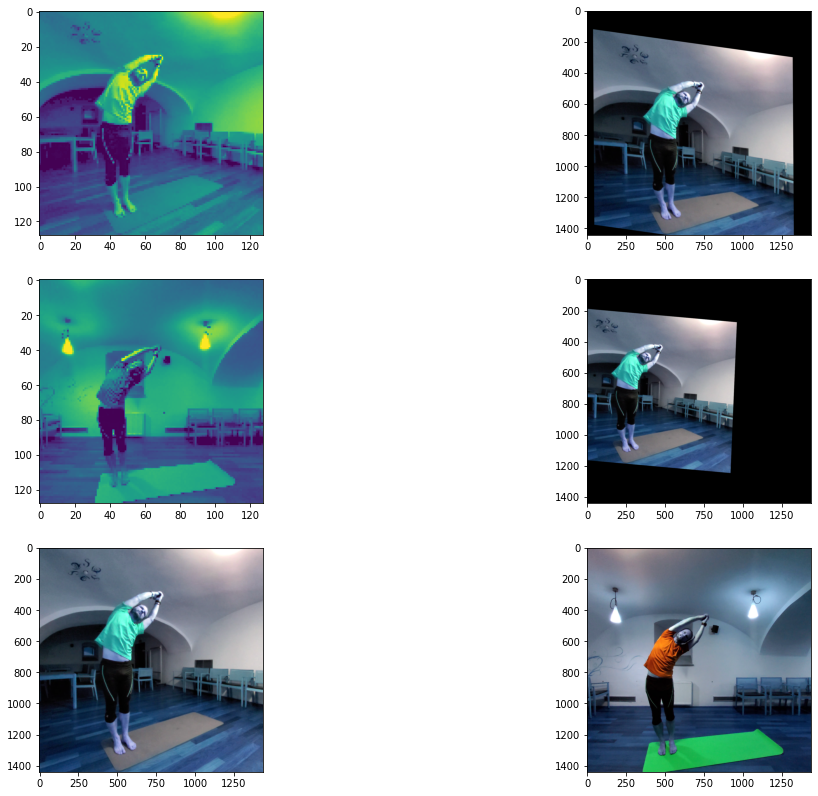

In [83]:
iteration = random.choice(iterations)
im, gt, DataFiles = iteration["batch"]

np.set_printoptions(precision=3, suppress=True)

print(f"Ground Truth :\n {np.array(gt[0].view(3,2))}")
print(f"Transofrm    :\n {np.array(iteration['outputs'][0].view(3,2).cpu())}")
print(f"loss: {iteration['loss']}")

src = cv2.imread(DataFiles['src'][0])
dst = cv2.imread(DataFiles['dst'][0])

groundPoints = np.array(gt.view(3,2))
# groundPoints = np.concatenate( (groundPoints, [[1], [1], [1],]), axis=1)

outputPoints = np.array(iteration['outputs'][0].view(3,2).cpu())
# outputPoints = np.concatenate( (outputPoints, [[1], [1], [1],]), axis=1)

srcPoints = np.array([ [0, 0], [1440, 1440], [0, 1440], ]).astype(np.float32)

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# src
axes[2][0].imshow(src)
# Taget
axes[2][1].imshow(dst)

# Ground Truth
gtTransform = cv2.getAffineTransform(srcPoints, groundPoints)
warped = cv2.warpAffine(src, gtTransform, (src.shape[1], src.shape[0]))
axes[0][1].imshow(warped)

# Network Result
outputTransform = cv2.getAffineTransform(srcPoints, outputPoints)
warped = cv2.warpAffine(src, outputTransform, (src.shape[1], src.shape[0]))
axes[1][1].imshow(warped)

# Network Imputs
axes[0][0].imshow(im[0][0].view(image_size,image_size))
axes[1][0].imshow(im[0][1].view(image_size,image_size))

In [84]:

# dst = cv2.imread("D:\\Skola\\ITT\\data03\\Bow\\Images\\Moon Salutation 201015 d.mkv_000020067.png", cv2.IMREAD_GRAYSCALE)
# dst = cv2.resize(dst, (image_size, image_size))

# dst2 = cv2.imread("D:\Skola\ITT\Data\Cobra\Images\\001.png", cv2.IMREAD_GRAYSCALE)
# dst2 = cv2.resize(dst, (image_size, image_size)) 

# fig, axes = plt.subplots(2, 3, figsize=(18, 14))
# axes[0][0].imshow(dst2)
# axes[1][0].imshow(dst)

print(loader_steps)

22
